# Quality Assessment Notebook for realism of quasar templates.

To-do for this notebook:
    - compute the EMPCA for mocks and data.
    - look the difference between the first eigenvectors for mocks and data.
    - look the difference of the mean between data and mocks.
    
Conclusion:
    - What parameter do we need to change in SIMQSO?

In [1]:
from __future__ import absolute_import, division, print_function

import sys, os
import random
import optparse
import glob
import subprocess
import scipy as sp
import scipy.constants
from scipy import interpolate
import matplotlib.pyplot as plt
import fitsio
from astropy.io import fits

from empca import empca
from desispec.interpolation import resample_flux
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


The next lines are only if one work in a local branch.

In [2]:
os.environ['PYTHONPATH']='/global/cscratch1/sd/rodcn25/desi/code/desisim/py:'+os.environ['PYTHONPATH']
os.environ['PATH']='/global/cscratch1/sd/rodcn25/desi/code/desisim/bin/:'+os.environ['PATH']

## Mocks

Let me start by analysing the SIMQSO mocks for to make empca. Let's need to use the restframe from the SIMQSO.

In [3]:
from desisim.templates import SIMQSO
simqso = SIMQSO(restframe=True)

Let's choose 1000 QSO spectra.

In [4]:
nqso = 1000
seed = 55
tflux, twave, tmeta, tmag = simqso.make_templates(nqso, seed=seed, zrange=(2, 4))
dw = 0.1
wave = np.arange(600, 10000, dw)
mask=(twave>550) & (twave <2000)

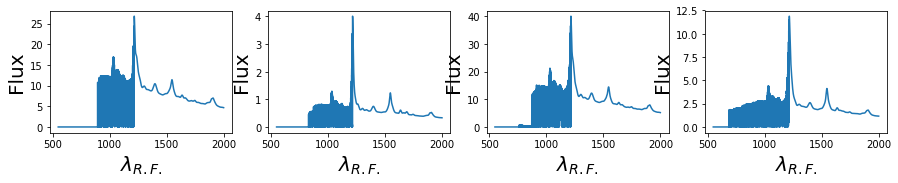

In [7]:
plt.figure(figsize=(15,13))
for i in range(nqso)[:4]:
    plt.subplot(5,4,i+1)
    flux=tflux[i]
    plt.plot(twave[mask],flux[mask])
    plt.xlabel('$\lambda_{R.F.}$',fontsize=20)
    plt.ylabel('Flux',fontsize=20)

In [8]:
qsoflux = np.zeros((nqso, wave.size))
for i in range(nqso):
    qsoflux[i] = resample_flux(wave, twave, tflux[i])

Normalizing the spectra.

In [9]:
for i in range(qsoflux.shape[0]):
    qsoflux[i] /= np.median(qsoflux[i])

Let's start the EMPCA for 20 eigenvector and 20 iterations.

In [55]:
model = empca.empca(qsoflux, niter=20, nvec=20)

       iter        R2             rchi2
EMPCA  1/20       0.00638032     19.36915339
EMPCA  2/20       0.93797969      0.92116731
EMPCA  3/20       0.94960074      0.74318481
EMPCA  4/20       0.95117047      0.72003927
EMPCA  5/20       0.95192014      0.70898448
EMPCA  6/20       0.95239403      0.70199585
EMPCA  7/20       0.95269087      0.69761806
EMPCA  8/20       0.95286886      0.69499308
EMPCA  9/20       0.95297404      0.69344206
EMPCA 10/20       0.95303700      0.69251364
EMPCA 11/20       0.95307584      0.69194106
EMPCA 12/20       0.95310080      0.69157311
EMPCA 13/20       0.95311766      0.69132460
EMPCA 14/20       0.95312970      0.69114706
EMPCA 15/20       0.95313883      0.69101244
EMPCA 16/20       0.95314618      0.69090413
EMPCA 17/20       0.95315243      0.69081199
EMPCA 18/20       0.95315801      0.69072971
EMPCA 19/20       0.95316320      0.69065326
EMPCA 20/20       0.95316816      0.69058007
R2: 0.953181285964


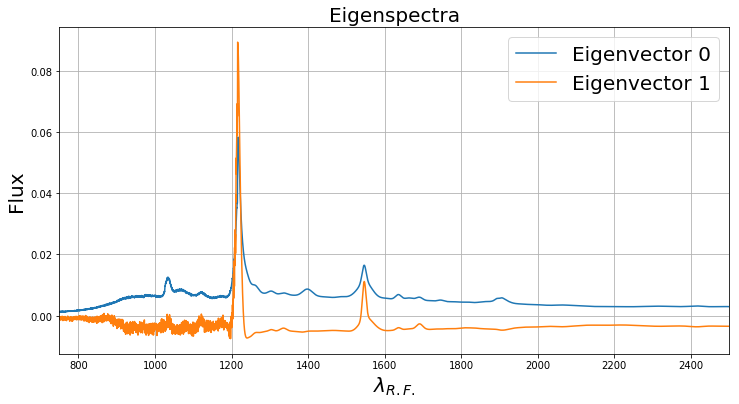

In [56]:
plt.figure(figsize=(12,6))
plt.title('Eigenspectra',fontsize=20)
pylab.plot(wave,model.eigvec[0], label='Eigenvector 0')
pylab.plot(wave,model.eigvec[1], label='Eigenvector 1')
#pylab.plot(model.eigvec[2], label='3 Eigenvector')
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('Flux', fontsize = 20) 
plt.xlim(750,2500)
plt.grid()
plt.legend(fontsize=20)

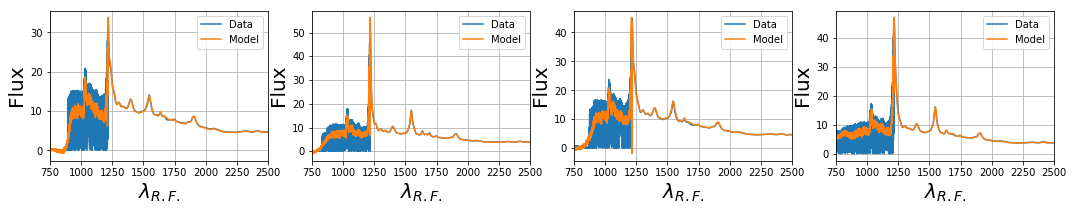

In [57]:
plt.figure(figsize=(18,16))
for i in range(nqso)[:4]:
    plt.subplot(5,4,i+1)
    pylab.plot(wave,model.data[i],label='Data')
    pylab.plot(wave,model.model[i], label='Model')
    plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
    plt.ylabel('Flux', fontsize = 20) 
    plt.xlim(750,2500)
    plt.grid()
    plt.legend()

## Now, for the data of BOSS DR14.

In [58]:
# Lyman-alpha from eqn 5 of Calura et al. 2012 (Arxiv: 1201.5121)
# Other from eqn 1.1 of Irsic et al. 2013 , (Arxiv: 1307.3403)
# Lyman-limit from abstract of Worseck et al. 2014 (Arxiv: 1402.4154)
Lyman_series = {
    'Lya'     : { 'line':1215.67,  'A':0.0023,          'B':3.64, 'var_evol':3.8 },
    'Lyb'     : { 'line':1025.72,  'A':0.0023/5.2615,   'B':3.64, 'var_evol':3.8 },
    'Ly3'     : { 'line':972.537,  'A':0.0023/14.356,   'B':3.64, 'var_evol':3.8 },
    'Ly4'     : { 'line':949.7431, 'A':0.0023/29.85984, 'B':3.64, 'var_evol':3.8 },
    'Ly5'     : { 'line':937.8035, 'A':0.0023/53.36202, 'B':3.64, 'var_evol':3.8 },
    #'LyLimit' : { 'line':911.8,    'A':0.0023,          'B':3.64, 'var_evol':3.8 },
}

In [59]:
def transmission_Lyman(zObj,lObs):
    '''Calculate the transmitted flux fraction from the Lyman series
    This returns the transmitted flux fraction:
        1 -> everything is transmitted (medium is transparent)
        0 -> nothing is transmitted (medium is opaque)
    Args:
        zObj (float): Redshift of object
        lObs (array of float): wavelength grid
    Returns:
        array of float: transmitted flux fraction
    '''

    lRF = lObs/(1.+zObj)
    T   = sp.ones(lObs.size)

    for l in list(Lyman_series.keys()):
        w      = lRF<Lyman_series[l]['line']
        zpix   = lObs[w]/Lyman_series[l]['line']-1.
        tauEff = Lyman_series[l]['A']*(1.+zpix)**Lyman_series[l]['B']
        T[w]  *= sp.exp(-tauEff)

    return T

In [60]:
def plot_spplate(path_to_data,plate,mjd,fiber):

    ###
    path = path_to_data+str(plate)+'/spPlate-' +str(plate)+'-'+str(mjd)+'.fits'

    cat = fitsio.FITS(path)
    psflux = cat[0].read()
    psivar = cat[1].read()
    end  = cat[2].read()
    h    = cat[4].read_header()
    cat.close()

    pswave = h['CRVAL1'] + h['CD1_1']*sp.arange(h['NAXIS1'])
    if h['DC-FLAG']:
        pswave = 10**pswave

    ###
    cut = (psivar[fiber-1,:]>0.) & (end[fiber-1,:]==0)
    pswave = pswave[cut]
    psflux = psflux[fiber-1,:][cut]
    psivar = psivar[fiber-1,:][cut]

    return pswave, psflux, psivar

In [61]:
def lines_list(path):

    lines = []
    fileLines = open(path)
    for l in fileLines:
        l = l.split()
        if l[0]=='#': continue
        lines += [ [float(l[1]),float(l[2])] ]
    fileLines.close()
    lines = sp.asarray(lines)

    return lines

In [62]:
def get_pca():

    ### Parameters
    path_spec      = '/project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0/'
    path_drq       = '/global/cscratch1/sd/rodcn25/lya/boss_data/DR14Q_v4_4.fits'
    path_lines     = '/global/homes/r/rodcn25/PCA/dr14-line-sky-mask.txt'
    nbObj  = 10000
    CRVAL1 = 2.6534
    CDELT1 = 0.0001
    NBLL   = 13637

    ### Get lines to veto
    lines = lines_list(path_lines)

    ### Get list qso
    data      = fitsio.FITS(path_drq)
    w  = sp.ones(data[1]['PLATE'][:].size).astype(bool)
    print('INFO: init              : ', w.sum())
    w &= data[1]['THING_ID'][:]>0.
    print('INFO: removed THID>=0   : ', w.sum())
    #print('INFO: removed THID<=0   : ', w.sum())
    w &= data[1]['Z_PCA'][:]>0.
    print('INFO: removed zvi>=0.   : ', w.sum())
    #print('INFO: removed zvi<=0.   : ', w.sum())
    plate   = data[1]['PLATE'][:][w]
    mjd     = data[1]['MJD'][:][w]
    fiberid = data[1]['FIBERID'][:][w]
    zvi     = data[1]['Z_PCA'][:][w]
    data.close()
    nsamples=100
    ### Random number of object
    sp.random.seed(10)
    listQSO = sp.arange(plate.size)
    randSelec = sp.array([])
    for i in sp.arange(0.,10.,0.1):
        w = (zvi>=i) & (zvi<i+0.1)
        if listQSO[w].size==0: continue
        r = sp.random.choice(listQSO[w], size=min(listQSO[w].size,nsamples), replace=False)
        randSelec = sp.append(randSelec,r)
    #randSelec = sp.append(randSelec,sp.random.choice(listQSO, size=nbObj, replace=False))
    randSelec = sp.unique(randSelec)
    randSelec = randSelec.astype(int)
    nbObj = randSelec.size
    print('INFO: size = ', nbObj)


    ### Get spectra
    ttwave = []
    ttflux = []
    ttivar = []
    for i in range(nbObj)[:700]: 
        #if i%10==0: print(i)
        r = randSelec[i]

        TMPwave, TMPflux, TMPivar = plot_spplate(path_spec,plate=plate[r],mjd=mjd[r],fiber=fiberid[r])
        TMPwaveRF = TMPwave/(1.+zvi[r])
        if TMPwave.size<500:
            print('INFO: removing size<10: {}'.format(TMPwave.size))
            continue

        ### Remove sky lines and CCD edge
        w = sp.ones_like(TMPwave).astype(bool)
        for l in lines:
            w &= (TMPwave<l[0]) | (TMPwave>l[1])
        w &= TMPwave>3600.
        w &= TMPwave<7235.
        TMPwave = TMPwave[w]
        TMPflux = TMPflux[w]
        TMPivar = TMPivar[w]
        TMPwaveRF = TMPwaveRF[w]
        if TMPwave.size<500:
            print('INFO: removing size<10: {}'.format(TMPwave.size))
            continue

        ### Correct for Lyman
        T = transmission_Lyman(zvi[r],TMPwave)
        TMPflux /= T
        TMPivar *= T**2

        ### Rescale by median
        mid = sp.median(TMPflux)
        if mid<=0.:
            print('INFO: removing med<=0: {}'.format(mid))
            continue
        TMPflux /= mid
        TMPivar *= mid**2

        ### Store
        ttwave += [TMPwaveRF]
        ttflux += [TMPflux]
        ttivar += [TMPivar]

    nbObj = len(ttwave)
    print('INFO: size = ', nbObj)

    ###
    pcawave    = 10**(CRVAL1+sp.arange(NBLL)*CDELT1)
    pcaflux    = sp.zeros((nbObj, pcawave.size))
    pcaivar    = sp.zeros((nbObj, pcawave.size))
    ### On same grid
    for i in range(nbObj):
        pcaflux[i],pcaivar[i] = resample_flux(pcawave, ttwave[i], ttflux[i], ttivar[i])
    pcaivar[pcaivar<0.] = 0.
    ### Remove if all measured bins are zero
    w    = sp.sum(pcaivar,axis=0)>0.
    pcawave = pcawave[w]
    pcaflux = pcaflux[:,w]
    pcaivar = pcaivar[:,w]
    ### Cap the ivar
    pcaivar[pcaivar>100.] = 100.

    ### Get the mean
    pca_0 = sp.average(pcaflux,weights=pcaivar,axis=0)
    for i in range(nbObj):
        w = pcaivar[i]>0.
        pcaflux[i,w] -= pca_0[w]

    ### PCA
    print('INFO: Starting PCA')
    model = empca.empca(pcaflux, weights=pcaivar, niter=20, nvec=20)
    for i in range(model.coeff.shape[0]):
        model.coeff[i] /= sp.linalg.norm(model.coeff[i])
        
    return model, pcawave, pcaflux, pcaivar, randSelec

In [63]:
model_empca, wave_empca, flux_empca, ivar_empca, rselec=get_pca()

INFO: init              :  526356
INFO: removed THID>=0   :  446137
INFO: removed zvi>=0.   :  444976
INFO: size =  4801
INFO: removing size<10: 12
INFO: removing size<10: 14
INFO: removing size<10: 14
INFO: size =  697
INFO: Starting PCA
       iter        R2             rchi2
EMPCA  1/20       0.04909668      3.40167227
EMPCA  2/20       0.30802487      1.65353726
EMPCA  3/20       0.40161467      1.38284233
EMPCA  4/20       0.38557326      1.28768217
EMPCA  5/20       0.42152312      1.28215721
EMPCA  6/20       0.48160730      1.17929863
EMPCA  7/20       0.45124816      1.16217297
EMPCA  8/20       0.50142461      1.19551255
EMPCA  9/20       0.49242820      1.12402544
EMPCA 10/20       0.48761023      1.08857998
EMPCA 11/20       0.33950728      1.55566787
EMPCA 12/20       0.49888693      1.43883558
EMPCA 13/20       0.56362589      1.20458738
EMPCA 14/20       0.50272591      1.63695441
EMPCA 15/20       0.57893818      1.10320391
EMPCA 16/20       0.53778916      1.14867698
E

Let's start looking the spectra that were taken. 

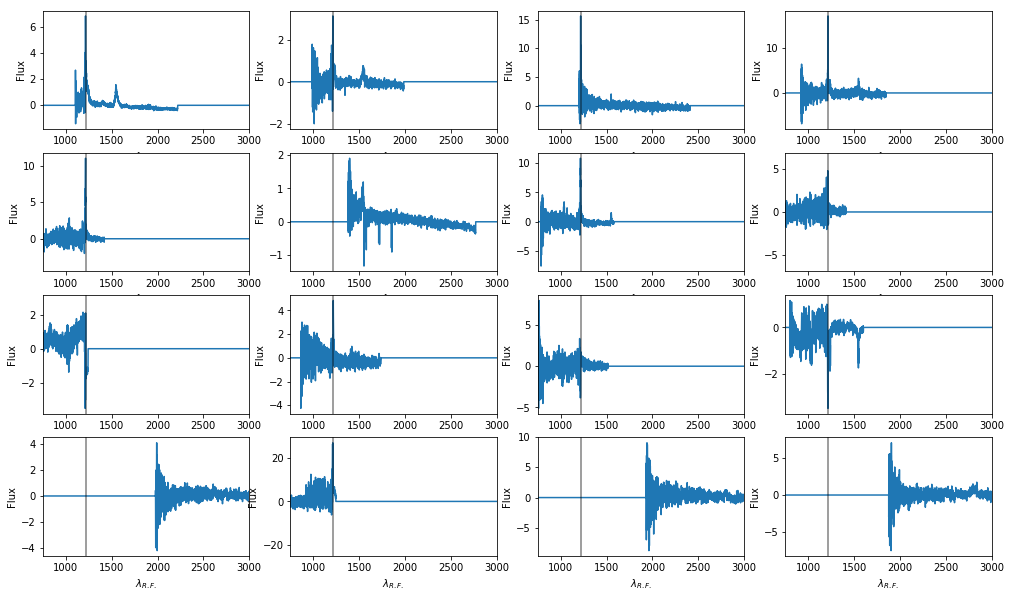

In [64]:
plt.figure(figsize=(17,65))
for i in range(len(flux_empca))[28:44]:
    plt.subplot(25,4,i+1)
    plt.plot(wave_empca,flux_empca[i])
    axvline(1216,color='k',alpha=0.5) # I choose the point of Ly-alpha peak.
    plt.xlabel('$\lambda_{R.F.}$', fontsize = 10)
    plt.ylabel('Flux', fontsize = 10)    
    plt.xlim(750,3000)

It seems that not all spectra have been correctly placed in the restframe. 

Now, I show the spectra with the output of empca called model. 

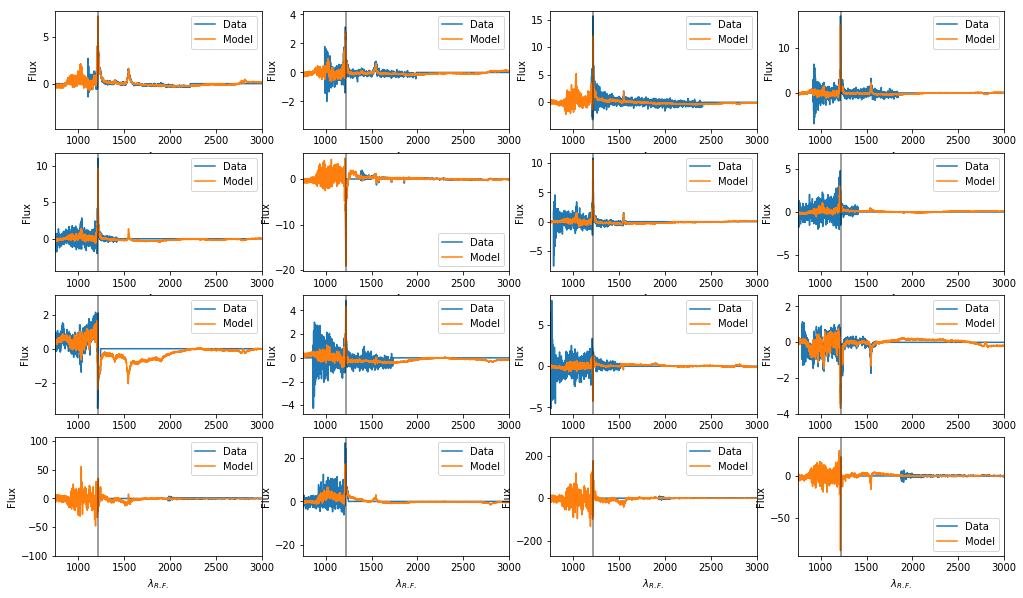

In [65]:
plt.figure(figsize=(17,65))
for j in range(len(model.data))[28:44]:
    plt.subplot(25,4,j+1)
    plt.plot(wave_empca,model_empca.data[j],label='Data')
    plt.plot(wave_empca,model_empca.model[j],label='Model')
    axvline(1216,color='k',alpha=0.5) # I choose the point of Ly-alpha peak.
    plt.xlabel('$\lambda_{R.F.}$', fontsize = 10)
    plt.ylabel('Flux', fontsize = 10)
    plt.xlim(750,3000)
    #plt.ylim(-10,10)
    plt.legend()

Let's look the firts two eigenspectra.

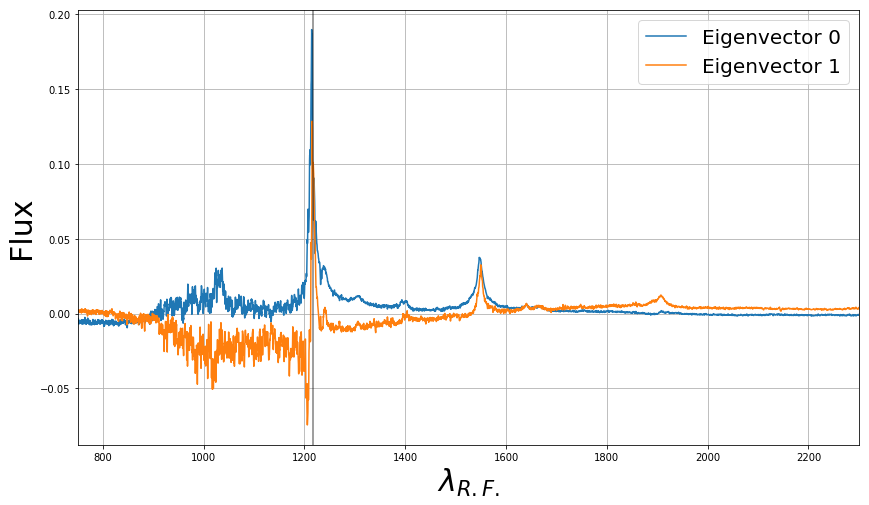

In [66]:
plt.figure(figsize=(14,8))
pylab.plot(wave_empca,model_empca.eigvec[0],label='Eigenvector 0')
pylab.plot(wave_empca,model_empca.eigvec[1],label='Eigenvector 1')
axvline(1216,color='k',alpha=0.5)
plt.xlim(750,2300)
#plt.ylim(-2.5,10)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 30)
plt.ylabel('Flux', fontsize = 30)
plt.grid()
plt.legend(fontsize = 20)

## Let's compare the eigenvectors between mocks and BOSS DR14 data.

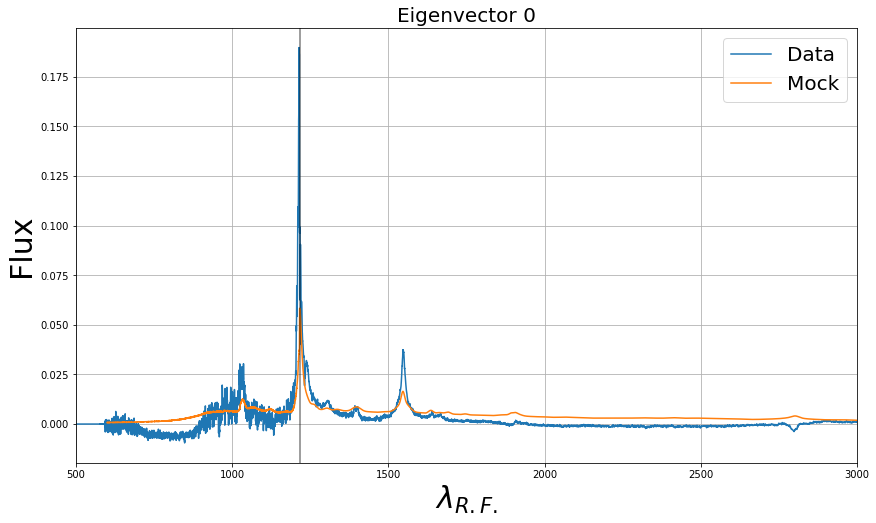

In [70]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 0',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[0],label='Data')
pylab.plot(wave,model.eigvec[0], label='Mock')
axvline(1216,color='k',alpha=0.5)
plt.xlim(500,3000)
#plt.ylim(-2.5,10)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 30)
plt.ylabel('Flux', fontsize = 30)
plt.grid()
plt.legend(fontsize = 20)

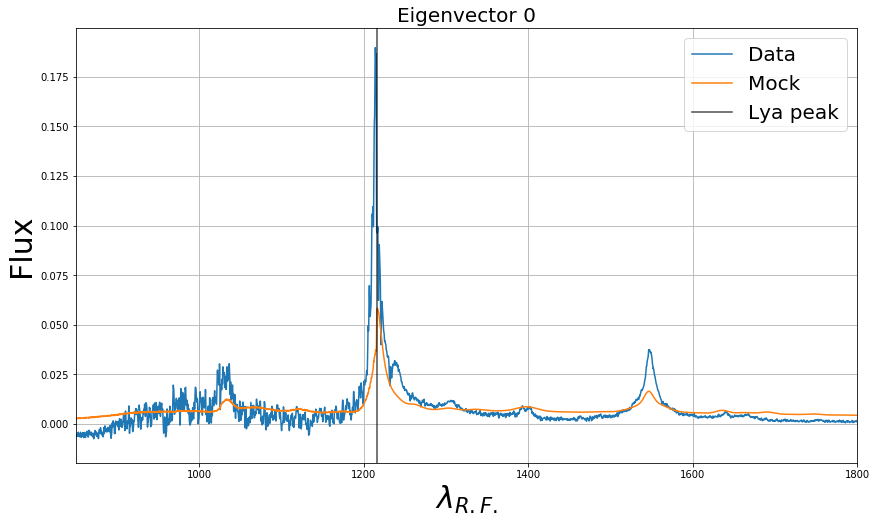

In [80]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 0',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[0],label='Data')
pylab.plot(wave,model.eigvec[0], label='Mock')
axvline(1216,color='k', label='Lya peak', alpha=0.7)
plt.xlim(850,1800)
#plt.ylim(-2.5,10)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 30)
plt.ylabel('Flux', fontsize = 30)
plt.grid()
plt.legend(fontsize = 20)

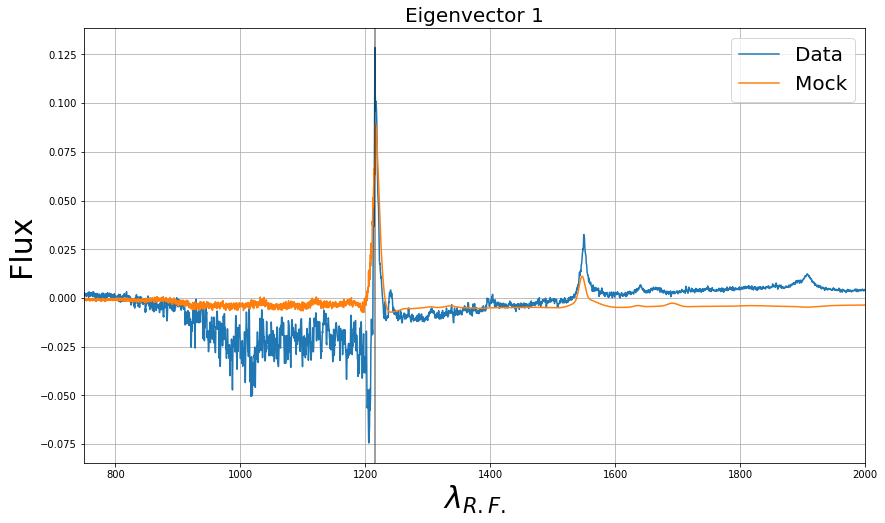

In [74]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 1',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[1],label='Data')
pylab.plot(wave,model.eigvec[1], label='Mock')
axvline(1216,color='k',alpha=0.5)
plt.xlim(750,2000)
#plt.ylim(-2.5,10)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 30)
plt.ylabel('Flux', fontsize = 30)
plt.grid()
plt.legend(fontsize = 20)

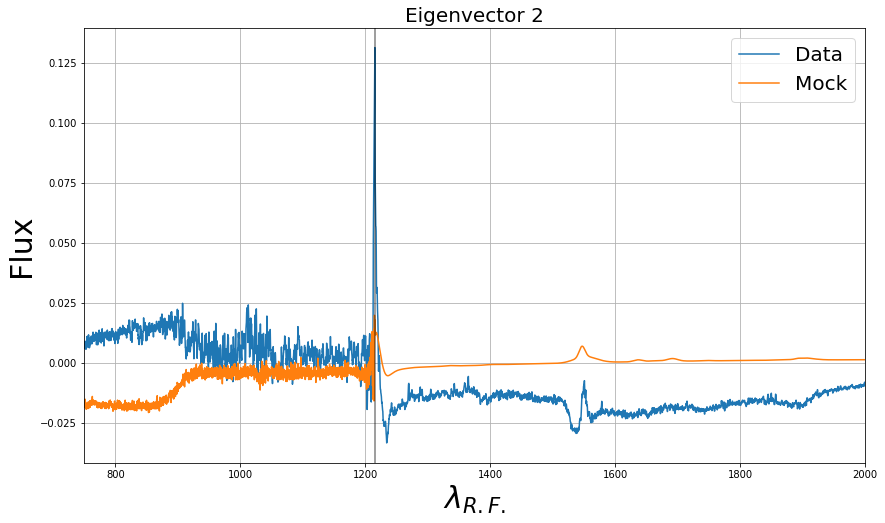

In [75]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 2',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[2],label='Data')
pylab.plot(wave,model.eigvec[2], label='Mock')
axvline(1216,color='k',alpha=0.5)
plt.xlim(750,2000)
#plt.ylim(-2.5,10)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 30)
plt.ylabel('Flux', fontsize = 30)
plt.grid()
plt.legend(fontsize = 20)

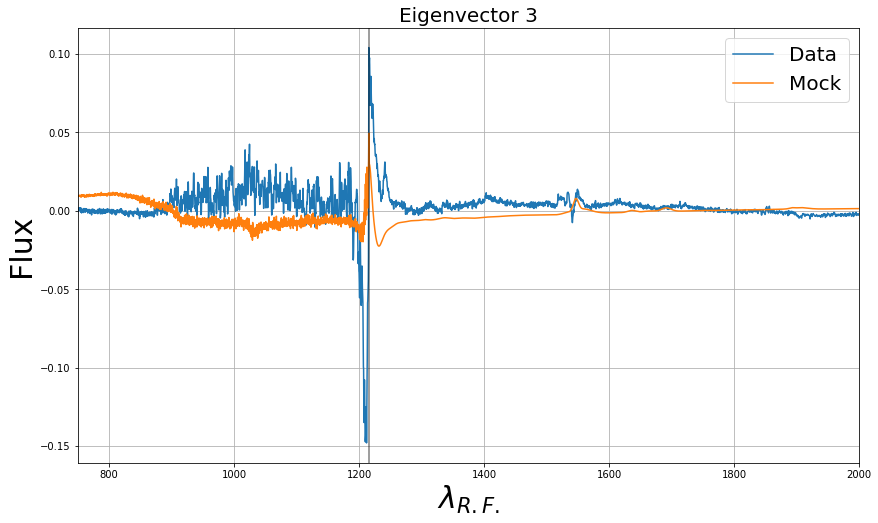

In [81]:
plt.figure(figsize=(14,8))
plt.title('Eigenvector 3',fontsize=20)
pylab.plot(wave_empca,model_empca.eigvec[3],label='Data')
pylab.plot(wave,model.eigvec[3], label='Mock')
axvline(1216,color='k',alpha=0.5)
plt.xlim(750,2000)
#plt.ylim(-2.5,10)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 30)
plt.ylabel('Flux', fontsize = 30)
plt.grid()
plt.legend(fontsize = 20)